idea : scrap IMDB for movie reviews and use them to improve the classification of the movie genre?
try different classifiers and see which one works best
try different vectorizers and see which one works best
try different preprocessing and see which one works best

In [20]:
import pandas as pd

train_df = pd.read_csv('Genre Classification Dataset-IMDB/train_data.txt', sep=':::', names=['Title', 'Genre', 'Description'], engine='python')
test_df = pd.read_csv('Genre Classification Dataset-IMDB/test_data.txt', sep=':::', names=['Title', 'Description'], engine='python')
test_df_solution = pd.read_csv('Genre Classification Dataset-IMDB/test_data_solution.txt', sep=':::', names=['Title', 'Genre', 'Description'], engine='python')

In [3]:
pd.set_option('display.max_colwidth', None)
print(len(train_df))
train_df.head()

54214


,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,"Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nobody has the courage to tell him. He only has a few weeks to live. Furious, he refuses to speak to anyone except straight-talking Rose, the lady in pink he meets on the hospital stairs. As Christmas approaches, Rose uses her fantastical experiences as a professional wrestler, her imagination, wit and charm to allow Oscar to live life and love to the full, in the company of his friends Pop Corn, Einstein, Bacon and childhood sweetheart Peggy Blue."
2,Cupid (1997),thriller,A brother and sister with a past incestuous relationship have a current murderous relationship. He murders the women who reject him and she murders the women who get too close to him.
3,"Young, Wild and Wonderful (1980)",adult,"As the bus empties the students for their field trip to the Museum of Natural History, little does the tour guide suspect that the students are there for more than just another tour. First, during the lecture films, the coeds drift into dreams of the most erotic fantasies one can imagine. After the films, they release the emotion of the fantasies in the most erotic and uncommon ways. One slips off to the curator's office for a little ""acquisition. "" Another finds the anthropologist to see what bones can be identified. Even the head teacher isn't immune. Soon the tour is over, but as the bus departs, everyone admits it was quite an education."
4,The Secret Sin (1915),drama,"To help their unemployed father make ends meet, Edith and her twin sister Grace work as seamstresses . An invalid, Grace falls prey to the temptations of Chinatown opium and becomes an addict, a condition worsened by a misguided physician who prescribes morphine to ease her pain. When their father strikes oil, the family enjoys a new prosperity and the sisters meet the eligible Jack Herron, a fellow oil prospector. To Grace's shock, Jack falls in love with Edith and in her jealousy, Grace tells Jack that Edith, not she, has a drug problem. Hinting that her sister will soon need more morphine, Grace arranges for a dinner in Chinatown with the couple. While her sister and Jack dance, Grace slips away to an opium den. Edith follows her, but ends up in the wrong den and is arrested in an ensuing drug raid. After he bails her out of jail, Edith takes an angry Jack to search for Grace and stumbles across her half-conscious body lying in the street. The truth about the sisters is revealed, and after sending Grace to a sanitarium in the country, Jack and Edith are married."
5,The Unrecovered (2007),drama,"The film's title refers not only to the un-recovered bodies at ground zero, but also to the state of the nation at large. Set in the hallucinatory period of time between September 11 and Halloween of 2001, The Unrecovered examines the effect of terror on the average mind, the way a state of heightened anxiety and/or alertness can cause the average person to make the sort of imaginative connections that are normally made only by artists and conspiracy theorists-both of whom figure prominently in this film. The Unrecovered explores the way in which irony, empathy, and paranoia relate to one another in the wake of 9/11."


Let's first look at the data distribution in the different classes

<Axes: xlabel='Genre'>

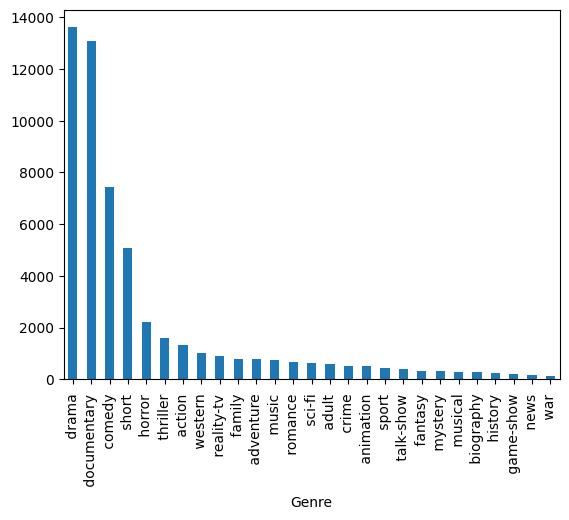

In [4]:
train_df['Genre'].value_counts().plot(kind='bar')

We notice that the data is pretty uneven. There are a lot of drama and documentary movies and very few news and war movies

Let's look at the distribution of the number of words in the description

<Axes: >

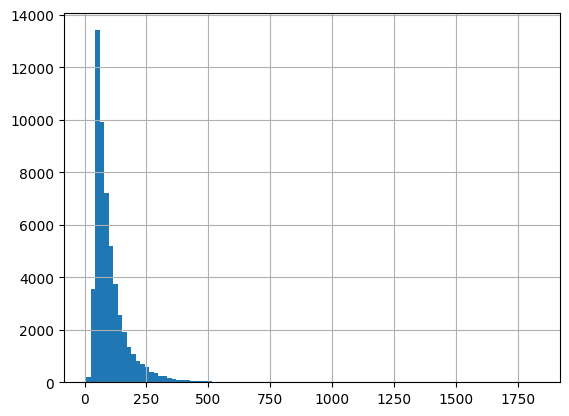

In [5]:
train_df['Description'].str.split().str.len().hist(bins=100)

We notice that most of the descriptions are between 0 and 100 words long

In [6]:
######################################
#cleaning the data ?
######################################


We can now start by vectorizing the descriptions

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
synopses_tfidf = vectorizer.fit_transform(train_df['Description'])

We can now use the vectorized descriptions to train a classifier. We will first try a kmeans classifier

In [8]:
from sklearn.cluster import KMeans
def fit_kmeans(data, n_clusters):
    """Fit a k-means classifier to some data.

    Arguments:
        data: The vectorized data to train the classifier on.
        n_clusters (int): The number of clusters.

    Returns:
        The trained k-means classifier.
    """
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto')
    kmeans.fit(data)
    return kmeans

In [9]:
n_clusters = train_df['Genre'].nunique()
kmeans = fit_kmeans(synopses_tfidf, n_clusters)

In [18]:
from sklearn.metrics import rand_score
gold_labels = train_df['Genre'].tolist()
pred_labels = kmeans.labels_
print(rand_score(pred_labels, gold_labels))

0.7874910371226242


we can now try on the test data

In [21]:
synopses_tfidf_test = vectorizer.transform(test_df['Description'])
pred_labels_test = kmeans.predict(synopses_tfidf_test)
gold_labels_test = test_df_solution['Genre'].tolist()
print(rand_score(pred_labels_test, gold_labels_test))

0.7890159470405936


We can now try to use a random forest classifier

In [42]:
from sklearn.ensemble import RandomForestClassifier
def fit_random_forest(data, labels, n_estimators=100, random_state=0):
    """Fit a random forest classifier to some data.

    Arguments:
        data: The vectorized data to train the classifier on.
        labels: The gold-standard labels.

    Returns:
        The trained random forest classifier.
    """
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    rf.fit(data, labels)
    return rf

In [43]:
rf = fit_random_forest(synopses_tfidf, gold_labels)

In [44]:
pred_labels = rf.predict(synopses_tfidf)
print(rand_score(pred_labels, gold_labels))

0.9997599900853035


In [45]:
pred_labels_test = rf.predict(synopses_tfidf_test)
print(rand_score(pred_labels_test, gold_labels_test))

0.6933589309970112


we can see that the random forest classifier overfits the training data.

In [46]:
#print number of features
print(rf.n_features_in_)

120800
